## Two Moons Normalizing Flow Using Distrax + Haiku
Here is an implementation of the Neural Spline Flow (`NSF`) based off of `distrax` [documentation](https://github.com/deepmind/distrax/blob/master/examples/flow.py) for a flow. For a more detailed walkthrough of the math behind normalizing flow, see this [notebook's](https://colab.research.google.com/github/nsanghi/probml-notebooks/blob/add_mnist_spline_flow_jax/notebooks/flow_spline_mnist_jax.ipynb#scrollTo=l0K_D4QX74gV) example using MNIST. Code to load 2 moons example dataset sourced from Chris Waites's jax-flows [demo](https://github.com/ChrisWaites/jax-flows/blob/master/examples/intro.ipynb).

In [1]:
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn import datasets, preprocessing
import jax
import jax.numpy as jnp
import numpy as np

try:
    from probml_utils import savefig, latexify
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify
try:
    import tensorflow as tf
except ModuleNotFoundError:
    %pip install -qq tensorflow
    import tensorflow as tf
try:
    import tensorflow_datasets as tfds
except ModuleNotFoundError:
    %pip install -qq tensorflow tensorflow_datasets
    import tensorflow_datasets as tfds
try:
    import distrax
except ModuleNotFoundError:
    %pip install -qq distrax
    import distrax
try:
    import haiku as hk
except ModuleNotFoundError:
    %pip install -qq -U dm-haiku
    import haiku as hk
try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax

try:
    from tensorflow_probability.substrates import jax as tfp
except ModuleNotFoundError:
    %pip install -qq tensorflow-probability
    from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 88 kB 5.9 MB/s 
     |████████████████████████████████| 272 kB 17.2 MB/s 
     |████████████████████████████████| 125 kB 57.3 MB/s 
     |████████████████████████████████| 72 kB 477 kB/s 
     |████████████████████████████████| 1.1 MB 41.5 MB/s 
     |████████████████████████████████| 342 kB 29.2 MB/s 
     |████████████████████████████████| 145 kB 33.0 MB/s 


# Plotting 2 moons dataset
Code taken directly from Chris Waites's jax-flows [demo](https://github.com/ChrisWaites/jax-flows/blob/master/examples/intro.ipynb). This is the distribution we want to create a bijection to from a simple base distribution, such as a gaussian distribution.

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


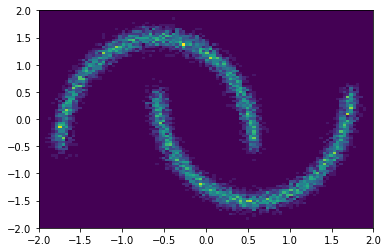

In [2]:
latexify(width_scale_factor=1, fig_height=1.5)
n_samples = 10000
plot_range = [(-2, 2), (-2, 2)]
n_bins = 100

scaler = preprocessing.StandardScaler()
X, _ = datasets.make_moons(n_samples=n_samples, noise=0.05)
X = scaler.fit_transform(X)
plt.hist2d(X[:, 0], X[:, 1], bins=n_bins, range=plot_range)[-1]

## Creating the normalizing flow in distrax+haiku
Instead of a uniform distribution, we use a Gaussian distribution as the base distribution. This makes more sense for a standardized two moons dataset that is scaled according to a normal distribution using `sklearn`'s `StandardScaler()`. Using a uniform base distribution will result in `inf` and `nan` loss.

In [3]:
from typing import Any, Iterator, Mapping, Optional, Sequence, Tuple

# Hyperparams - change these to experiment
flow_num_layers = 8
mlp_num_layers = 4
hidden_size = 1000
num_bins = 8
batch_size = 512
learning_rate = 1e-4
eval_frequency = 100

Array = jnp.ndarray
PRNGKey = Array
Batch = Mapping[str, np.ndarray]
OptState = Any


# Functions to create a distrax normalizing flow
def make_conditioner(
    event_shape: Sequence[int], hidden_sizes: Sequence[int], num_bijector_params: int
) -> hk.Sequential:
    """Creates an MLP conditioner for each layer of the flow."""
    return hk.Sequential(
        [
            hk.Flatten(preserve_dims=-len(event_shape)),
            hk.nets.MLP(hidden_sizes, activate_final=True),
            # We initialize this linear layer to zero so that the flow is initialized
            # to the identity function.
            hk.Linear(np.prod(event_shape) * num_bijector_params, w_init=jnp.zeros, b_init=jnp.zeros),
            hk.Reshape(tuple(event_shape) + (num_bijector_params,), preserve_dims=-1),
        ]
    )


def make_flow_model(
    event_shape: Sequence[int], num_layers: int, hidden_sizes: Sequence[int], num_bins: int
) -> distrax.Transformed:
    """Creates the flow model."""
    # Alternating binary mask.
    mask = jnp.arange(0, np.prod(event_shape)) % 2
    mask = jnp.reshape(mask, event_shape)
    mask = mask.astype(bool)

    def bijector_fn(params: Array):
        return distrax.RationalQuadraticSpline(params, range_min=-2.0, range_max=2.0)

    # Number of parameters for the rational-quadratic spline:
    # - `num_bins` bin widths
    # - `num_bins` bin heights
    # - `num_bins + 1` knot slopes
    # for a total of `3 * num_bins + 1` parameters.
    num_bijector_params = 3 * num_bins + 1

    layers = []
    for _ in range(num_layers):
        layer = distrax.MaskedCoupling(
            mask=mask,
            bijector=bijector_fn,
            conditioner=make_conditioner(event_shape, hidden_sizes, num_bijector_params),
        )
        layers.append(layer)
        # Flip the mask after each layer.
        mask = jnp.logical_not(mask)

    # We invert the flow so that the `forward` method is called with `log_prob`.
    flow = distrax.Inverse(distrax.Chain(layers))

    # Making base distribution normal distribution
    mu = jnp.zeros(event_shape)
    sigma = jnp.ones(event_shape)
    base_distribution = distrax.Independent(distrax.MultivariateNormalDiag(mu, sigma))
    return distrax.Transformed(base_distribution, flow)


def load_dataset(split: tfds.Split, batch_size: int) -> Iterator[Batch]:
    # ds = tfds.load("mnist", split=split, shuffle_files=True)
    ds = split
    ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=1000)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))


def prepare_data(batch: Batch, prng_key: Optional[PRNGKey] = None) -> Array:
    data = batch.astype(np.float32)
    return data


@hk.without_apply_rng
@hk.transform
def model_sample(key: PRNGKey, num_samples: int) -> Array:
    model = make_flow_model(
        event_shape=TWO_MOONS_SHAPE,
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins,
    )
    return model.sample(seed=key, sample_shape=[num_samples])


@hk.without_apply_rng
@hk.transform
def log_prob(data: Array) -> Array:
    model = make_flow_model(
        event_shape=TWO_MOONS_SHAPE,
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins,
    )
    return model.log_prob(data)


def loss_fn(params: hk.Params, prng_key: PRNGKey, batch: Batch) -> Array:
    data = prepare_data(batch, prng_key)
    # Loss is average negative log likelihood.
    loss = -jnp.mean(log_prob.apply(params, data))
    return loss


@jax.jit
def eval_fn(params: hk.Params, batch: Batch) -> Array:
    data = prepare_data(batch)  # We don't dequantize during evaluation.
    loss = -jnp.mean(log_prob.apply(params, data))
    return loss

## Setting up the optimizer

In [4]:
optimizer = optax.adam(learning_rate)


@jax.jit
def update(params: hk.Params, prng_key: PRNGKey, opt_state: OptState, batch: Batch) -> Tuple[hk.Params, OptState]:
    """Single SGD update step."""
    grads = jax.grad(loss_fn)(params, prng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

## Training the flow


In [ ]:
# Event shape - only two dimensions
TWO_MOONS_SHAPE = (2,)

# Create tf dataset from sklearn dataset
dataset = tf.data.Dataset.from_tensor_slices(X)

# Splitting into train/validate ds
train = dataset.skip(2000)
val = dataset.take(2000)

# load_dataset(split: tfds.Split, batch_size: int)
train_ds = load_dataset(train, 512)
valid_ds = load_dataset(val, 512)

# Initializing PRNG and Neural Net params
prng_seq = hk.PRNGSequence(1)
params = log_prob.init(next(prng_seq), np.zeros((1, *TWO_MOONS_SHAPE)))
opt_state = optimizer.init(params)

training_steps = 4000

for step in range(training_steps):
    params, opt_state = update(params, next(prng_seq), opt_state, next(train_ds))

    if step % eval_frequency == 0:
        val_loss = eval_fn(params, next(valid_ds))
        print(f"STEP: {step:5d}; Validation loss: {val_loss:.3f}")

STEP:     0; Validation loss: 2.826
STEP:   100; Validation loss: 1.605
STEP:   200; Validation loss: 1.486
STEP:   300; Validation loss: 1.321
STEP:   400; Validation loss: 1.288
STEP:   500; Validation loss: 1.356
STEP:   600; Validation loss: 1.365
STEP:   700; Validation loss: 1.268
STEP:   800; Validation loss: 1.292
STEP:   900; Validation loss: 1.273
STEP:  1000; Validation loss: 1.366
STEP:  1100; Validation loss: 1.300
STEP:  1200; Validation loss: 1.300
STEP:  1300; Validation loss: 1.329
STEP:  1400; Validation loss: 1.291
STEP:  1500; Validation loss: 1.287
STEP:  1600; Validation loss: 1.305
STEP:  1700; Validation loss: 1.354
STEP:  1800; Validation loss: 1.292
STEP:  1900; Validation loss: 1.297
STEP:  2000; Validation loss: 1.276
STEP:  2100; Validation loss: 1.323
STEP:  2200; Validation loss: 1.322
STEP:  2300; Validation loss: 1.329
STEP:  2400; Validation loss: 1.302
STEP:  2500; Validation loss: 1.329
STEP:  2600; Validation loss: 1.313
STEP:  2700; Validation loss

We can now look at the trained flow's output. It should be the same, or close, to the original Two Moons dataset that we are trying to model.

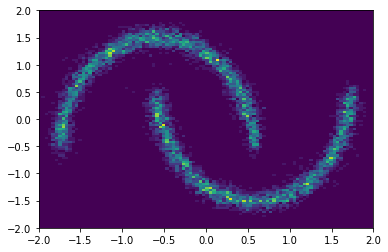

In [10]:
n_samples = 10000
plot_range = [(-2, 2), (-2, 2)]
n_bins = 100

X_transf = model_sample.apply(params, next(prng_seq), num_samples=n_samples)
plt.hist2d(X_transf[:, 0], X_transf[:, 1], bins=n_bins, range=plot_range)[-1]

plt.savefig("two-moons-nsf-flow.pdf")
plt.savefig("two-moons-nsf-flow.png")
plt.show()

To sample intermediate layers, need to get `haiku` parameters and match those to intermediate layers of the NSF. This isn't trivial but we can use the names of the modules to group them and then use those to sample from the base gaussian. To get the parameters, we need to parse the keys that `haiku` uses to store parameter values from each module. For the `NSF` flow, each layer is composed of an affine transformation and series of `MLPs` to condition the masked coupling layer. To parse, we'll use some regex to determine the key name and use that to find the indices of the ordered dictionary of each layer. We'll collect each layer in a list within a larger list of all the lists.

Maybe we could have used better naming convention, but we leave that as an exercise for the reader.

In [11]:
import re

params_list = params.keys()
layer_indices = []

for i in range(flow_num_layers):

    p = re.compile(f".*{i}/.|^linear_{i}$")
    start_p = re.compile(f"^mlp/.|^linear$")

    # re.findall([key for key in params.keys()], p)
    # print([i for i, string in enumerate(params_list) if re.findall(p, string) != []])
    if i == 0:
        layer_indices.append([i for i, string in enumerate(params_list) if re.findall(start_p, string) != []])
        continue
    layer_indices.append([i for i, string in enumerate(params_list) if re.findall(p, string) != []])

params_list = [key for key in params_list]

outer_list = []

for i in layer_indices:
    inner_list = []
    for j in i:
        inner_list.append(params_list[j])
    outer_list.append(inner_list)

We now can use a `haiku` data structure (`filter`) to get the params according to the list of the module neames we've collected. Thus, we have a list of the layers' parameters.

To sample sequential layers, we need the cumulative parameters up to that layer. Those will be the parameters that we'll use in our asmple function, whose skeleton is made for the number of layers we seek to sample.

Text(99.125, 0.5, 'NSF')

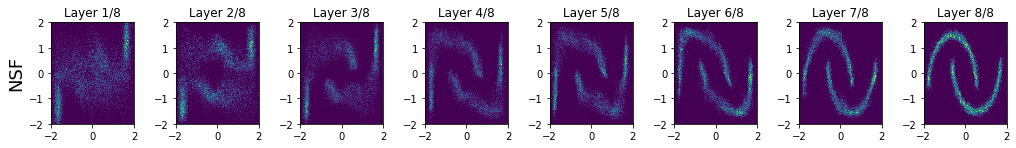

In [15]:
fig, axes = plt.subplots(ncols=flow_num_layers, figsize=(14, 2))
fig.tight_layout()

# Loop it.
for i in range(1, flow_num_layers + 1):

    @hk.without_apply_rng
    @hk.transform
    def model_sample(key: PRNGKey, num_samples: int) -> Array:
        model = make_flow_model(
            event_shape=TWO_MOONS_SHAPE,
            num_layers=i,  # Only thing that changes here....
            hidden_sizes=[hidden_size] * mlp_num_layers,
            num_bins=num_bins,
        )
        return model.sample(seed=key, sample_shape=[num_samples])

    # Accumulate the parameters you want to use
    keys = sum(outer_list[:i], [])

    # Get new dictionary based on the new keys
    temp_params = dict(filter(lambda x: x[0] in keys, params.items()))

    # Sample and plot
    X_transf = model_sample.apply(temp_params, next(prng_seq), num_samples=n_samples)
    axes[i - 1].hist2d(X_transf[:, 0], X_transf[:, 1], bins=n_bins, range=plot_range)[-1]
    axes[i - 1].set_title(f"Layer {i}/8")

axes[0].set_ylabel("NSF", fontsize=18)

In [16]:
fig.savefig("two-moons-nsf.pdf", bbox_inches="tight")
fig.savefig("two-moons-nsf.png", bbox_inches="tight")